# Stock directional movement predictor
This notebook explores the feasibility of a variety of machine learning algorithms in predicting directional movements of stock (whether the stock will go up or down over a given time in the future). Features for prediction are predominately conventional technical indicators which I hope to expand in the future.

In [12]:
import numpy as np
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime as dt
import pandas_datareader as web
from matplotlib import pyplot as plt

In [2]:
from google.colab import files
f=files.upload()

Saving AAPL.csv to AAPL.csv


In [3]:
f2=files.upload()

Saving SPY.csv to SPY.csv


# Importing data and processing
Reading in data from Apple and SPY which we will use as our training data. Apple being the stock and SPY being the ETF which is representative of the index S&P 500 within which Apple belongs.

In [4]:
apl_df=pd.read_csv('AAPL.csv')
spy_df=pd.read_csv('SPY.csv')
apl_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227114,452312000
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250017,817073600
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.260514,739396000
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.250017,412356000
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.252879,373699200


In [5]:
def prepare(df):
  df.index = pd.to_datetime(df['Date'])
  df=df.drop(['Date'], axis='columns')
  df=df[['Close', 'Volume']]
  return df

apl_df=prepare(apl_df)
spy_df=prepare(spy_df)
apl_df.tail()

,Close,Volume
Date,,
2022-07-15,150.169998,76030800
2022-07-18,147.070007,81420900
2022-07-19,151.000000,82982400
2022-07-20,153.039993,64823400
2022-07-21,155.350006,64953600


In [6]:
days_in_past=20
look_forward=10

# Features
Below we calculate all the features we will be inputting into the model. Currently this is a momentum indicator, volatility indicator, RSI and average volume.

In [7]:
def movement(row):
  if row['mreturns']>1:
    return 1
  else:
    return 0

def RSI(df):
  deltas=df['Close'].diff()
  deltas.dropna(inplace=True)
  pos=deltas.copy()
  neg=deltas.copy()
  pos[pos<0]=0
  neg[neg>0]=0
  av_gain=pos.rolling(14).mean() #RSI usually only has a lookback of 14 days
  av_loss=abs(neg.rolling(14).mean())
  rel_strength=av_gain/av_loss
  RSI=100-(100/(1+rel_strength))
  df['RSI']=RSI.shift(1) # So the row for any given date will contain the the RSI for the date before that we will use to make judgement
  return df




def feature_calc(df, n, m):
  '''
  Use n days in the past for feature calculations. 
  m is the number of days in the future we want to predict 
  the price movement for.
  '''
  df['mreturns']=df['Close'].shift(-m)/df['Close'] # Calculates return will get in next m days, what we want to predict
  df['returns']=df['Close']/df['Close'].shift(1) # Calculates daily returns on the stock from day before
  df['Move']=df.apply(lambda row: movement(row), axis=1) # Signal 1 if stock will move up in next m days
  df['momentum']=df['returns'].rolling(n).mean().shift(1) # The n shift now removed as we have adjusted returns - gives us the features up to that date not including
  df['volatility']=df['returns'].rolling(n).std().shift(1) # volatility from n days before up to this date
  df['volume']=df['Volume'].rolling(n).mean().shift(1) # Average of volume from last n days discluding current date
  df=RSI(df)
  df.dropna(inplace=True)
  return df

apl_df=feature_calc(apl_df, days_in_past, look_forward) 
spy_df=feature_calc(spy_df, days_in_past, look_forward)

apl_df.tail(10)

,Close,Volume,mreturns,returns,Move,momentum,volatility,volume,RSI
Date,,,,,,,,,
2022-06-23,138.270004,72433800,1.063427,1.021574,1,0.997521,0.025236,88348240.0,34.727928
2022-06-24,141.660004,89116800,1.022660,1.024517,1,0.999560,0.025460,86763295.0,35.348720
2022-06-27,141.660004,70207900,1.029648,1.000000,1,1.000729,0.026065,86595000.0,45.541702
2022-06-28,137.440002,67083400,1.058571,0.970210,1,0.999569,0.025523,85575320.0,44.531253
2022-06-29,139.229996,66242400,1.066365,1.013024,1,0.996042,0.024381,84380565.0,36.775390
2022-06-30,136.720001,98964500,1.098376,0.981972,1,0.996960,0.024670,82506765.0,39.999979
2022-07-01,138.929993,71007500,1.058591,1.016164,1,0.996103,0.024888,83740660.0,42.752198
2022-07-05,141.559998,73353800,1.066686,1.018930,1,0.996070,0.024860,83673630.0,52.397430
2022-07-06,142.919998,74064300,1.070809,1.009607,1,0.998945,0.023953,82912805.0,63.860260


In [8]:
# Now we have to make one big dataframe containing all the features of the dataset that we want to train with
def Join(df1,df2):
  df1['momentum_ind']=df2['momentum']
  df1['volatility_ind']=df2['volatility']
  df1['Volume_ind']=df2['Volume']
  df1['RSI_ind']=df2['RSI']
  return df1

apl_df=Join(apl_df, spy_df)

Now we can create the training and test dataset for our models.

In [9]:
features=['momentum', 'volatility', 'momentum_ind', 'volatility_ind', 'Volume', 'Volume_ind', 'RSI', 'RSI_ind'] #With RSI gives very high accuracy o something dodgy going on

def Split_data(df):
  X=df[features]
  y=df['Move']
  y=np.array(y)

  split_per = 0.8
  split=int(split_per*len(df))

  X_train=X[:split]
  y_train=y[:split]

  X_test=X[split:]
  y_test=y[split:]

  scaler=preprocessing.StandardScaler()
  X_train_s=scaler.fit_transform(X_train)
  X_test_s=scaler.fit_transform(X_test)
  return X_train_s, y_train, X_test_s, y_test

X_train_s, y_train, X_test_s, y_test = Split_data(apl_df)

# Training model - SVM
Below we create a simple SVM model and fit it to the training data.



In [10]:
classifier=svm.SVC().fit(X_train_s, y_train)

def accuracies(X_train, X_test, y_train, y_test, classifier):
  y_pred=classifier.predict(X_test)
  y_pred2=classifier.predict(X_train)
  acc=accuracy_score(y_test, y_pred)
  print('Train accuracy: ', accuracy_score(y_train, y_pred2))
  print('Test accuracy: ', acc)
  return y_pred, y_pred2, acc

y_pred, y_pred2, acc=accuracies(X_train_s, X_test_s, y_train, y_test, classifier)


Train accuracy:  0.6472634508348795
Test accuracy:  0.6024096385542169


We get a model accuracy of around 60% on the test data using n=20 and m=10

We have executed the above code for a ten days look forward time period, but it would be useful to loop over a variety of different look forward times to see which has the most accuracy. We will keep the number of days in the past we use for the techincal indicators the same for now, but I hope to change this as well to maximise accuracy.

In [13]:

def optimise(df1,df2):
  df_a=prepare(df1)
  df_b=prepare(df2)
  ms=[]
  accs=[]
  for m in range(5,150,10):
    ms.append(m)
    df_a=feature_calc(df_a, days_in_past, m)
    df_b=feature_calc(df_b, days_in_past, m)
    df=Join(df_a,df_b)
    X_train, y_train, X_test, y_test = Split_data(df)
    clf=svm.SVC().fit(X_train, y_train)
    y1, y2, acc=accuracies(X_train, X_test, y_train, y_test, clf)
    accs.append(acc)
  plt.figure(figsize=(12,7))
  plt.plot(ms, accs)
  plt.xlabel('m')
  plt.ylabel('accuracy')
  return accs


Train accuracy:  0.616079703429101
Test accuracy:  0.5796296296296296
Train accuracy:  0.6674440298507462
Test accuracy:  0.6222014925373134
Train accuracy:  0.6847800517525288
Test accuracy:  0.6190028222013171
Train accuracy:  0.7058963385639563
Test accuracy:  0.6321292775665399
Train accuracy:  0.7291114856730074
Test accuracy:  0.6775745909528392
Train accuracy:  0.7333822091886608
Test accuracy:  0.7109375
Train accuracy:  0.7447813121272365
Test accuracy:  0.7335984095427436
Train accuracy:  0.7618444388142893
Test accuracy:  0.7629179331306991
Train accuracy:  0.7711030554117038
Test accuracy:  0.8012422360248447
Train accuracy:  0.7744759883258159
Test accuracy:  0.8176033934252386
Train accuracy:  0.7960741548527808
Test accuracy:  0.7908496732026143
Train accuracy:  0.8103932584269663
Test accuracy:  0.7797752808988764
Train accuracy:  0.8295091489979669
Test accuracy:  0.7247386759581882
Train accuracy:  0.8402652200120555
Test accuracy:  0.6843373493975904
Train accuracy: 

[0.5796296296296296,
 0.6222014925373134,
 0.6190028222013171,
 0.6321292775665399,
 0.6775745909528392,
 0.7109375,
 0.7335984095427436,
 0.7629179331306991,
 0.8012422360248447,
 0.8176033934252386,
 0.7908496732026143,
 0.7797752808988764,
 0.7247386759581882,
 0.6843373493975904,
 0.7151819322459222]

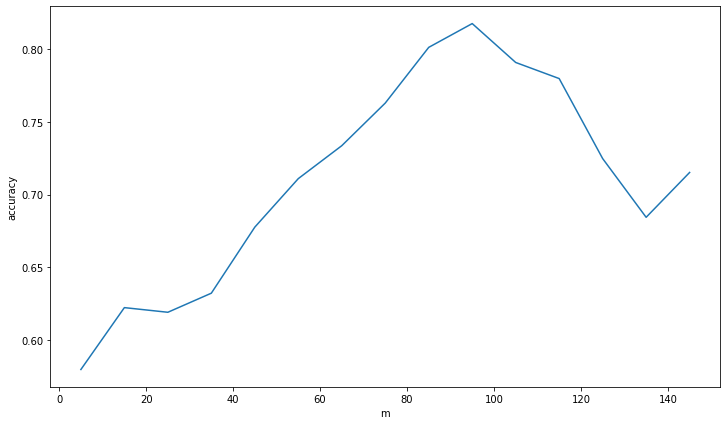

In [14]:
optimise(pd.read_csv('AAPL.csv'), pd.read_csv('SPY.csv'))

Note in general the accuracy increases because of the general tendency of the stock to go up and so most of the training data will have an upwards signal and so the model also adapts this approach by predicting mostly upward movements and generating a higher accuracy. This would not be useful for a trading strategy as it is not too different to just going long the stock. We explore this further using confusion matrices below.

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [16]:
def conf_matrix(y,y_pred):
  cf_matrix = confusion_matrix(y, y_pred)
  sns.heatmap(cf_matrix, annot=True)

In [17]:
def model_tester(df1, df2, n, m):
  df_a=prepare(df1)
  df_b=prepare(df2)
  df_a=feature_calc(df_a, n, m)
  df_b=feature_calc(df_b, n, m)
  df=Join(df_a,df_b)
  X_train, y_train, X_test, y_test = Split_data(df)
  clf=svm.SVC().fit(X_train, y_train)
  y1, y2, acc=accuracies(X_train, X_test, y_train, y_test, clf)
  conf_matrix(y_test, y1)
  return y1





Train accuracy:  0.8007075471698113
Test accuracy:  0.7766258246936852


array([1, 1, 1, ..., 1, 1, 1])

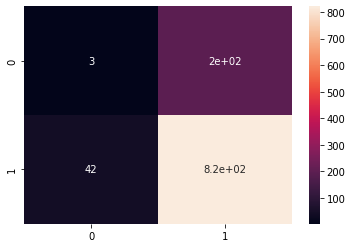

In [18]:
model_tester(pd.read_csv('AAPL.csv'), pd.read_csv('SPY.csv'), 20, 100)

We see that the testing data predominately has labels 1 which the model mostly predicts correctly giving it a higher accuracy as the model has been trained to mostly guess one due to the nature of the increasing stock training data.

# Implementing strategy
Once we have a model, we can implement a trading strategy. A simple way of doing this is every m days we get a signal whether to buy the stock or short it. If we are already long the stock and get a signal to buy nothing happens, if however, we don't have a long position on the stock then we buy it. Similarly if we get a 0 signal and we are currently long the stock then we sell. 

In [19]:
apl_t1=apl_df.iloc[::look_forward,:] # Make a dataframe containing every 10th day data with features from past n days, should techincally be 80% onwards but since test and train have roughly same accuracy just using this for more data
apl_t1

,Close,Volume,mreturns,returns,Move,momentum,volatility,volume,RSI,momentum_ind,volatility_ind,Volume_ind,RSI_ind
Date,,,,,,,,,,,,,
2001-02-01,0.377232,369695200,0.949705,0.976878,0,1.020088,0.051266,662857440.0,75.155269,1.003195,0.014723,8239100,75.800516
2001-02-15,0.358259,311416000,0.959501,1.028847,0,1.008473,0.047260,566254080.0,47.445112,0.999512,0.008778,5929800,36.438126
2001-03-02,0.343750,406201600,1.019479,1.026668,1,0.993470,0.034612,367711400.0,38.235003,0.995334,0.012411,12564300,29.810446
2001-03-16,0.350446,470316000,1.124587,0.996823,1,1.001289,0.041136,381355520.0,54.117672,0.994387,0.016758,58514600,35.358006
2001-03-30,0.394107,400349600,0.971454,0.979583,0,1.010211,0.045546,503412560.0,58.944672,0.996401,0.020179,9183600,37.594450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,152.059998,131577900,0.941142,0.966811,0,0.995809,0.025601,92972440.0,41.629048,0.995822,0.018716,155586100,37.104114
2022-05-23,143.110001,117726300,1.039131,1.040119,1,0.992408,0.031543,117154870.0,32.850639,0.995764,0.021480,76414900,36.407393
2022-06-07,148.710007,67808200,0.910161,1.017586,0,0.996740,0.029143,107045775.0,50.691251,1.000210,0.018040,59272400,57.265276


In [20]:
def m_day_preds(df, classifier):
  '''
  Takes a dataframe applies the classifier to the dataframe and records all the predictions.
  The function then also outputs the accuracy of the classifier
  '''

  X=df[features]
  y=df['Move']
  y=np.array(y)
  scaler=preprocessing.StandardScaler()
  X=scaler.fit_transform(X)
  y_predicted=classifier.predict(X)
  print('The accuracy for the m day strategy is: ',accuracy_score(y, y_predicted))
  return y_predicted

pred_m_day_moves=m_day_preds(apl_t1, classifier)

The accuracy for the m day strategy is:  0.6370370370370371


In [22]:

def add_cash(df):
  cash=[] # Will store how much cash you have after making that days trades
  if df.predictions[0]==1:
    cash.append(0)
  else:
    cash.append(df.Close[0])
  for index in range(1, df.shape[0]):
    if df.predictions[index]==1 and df.predictions[index-1]==0:
      cash.append(cash[index-1]-df.Close[index])
    elif df.predictions[index]==0 and df.predictions[index-1]==1:
      cash.append(cash[index-1]+df.Close[index])
    else:
      if cash[index-1]<0:
        cash.append(0)    # If the cash for the m days before was negative and we are still in same position then we have neutralised the cash
                          # position by additional investment. This is merely conventional and due to how add_Costs is defined doesn't make diff to results from previous method
      else:
        cash.append(cash[index-1])
  df['Cash']=cash
  print(len(cash))
  return df


def add_Costs(df):
  add_cost=[0]
  for i in range(1, df.shape[0]):
    if df.predictions[i-1]==0 and df.predictions[i]==1:
      if df.Cash[i]<0:
        add_cost.append(-df.Cash[i])
      else:
        add_cost.append(0)
    else:
      add_cost.append(0)
  df['add_costs']=add_cost
  return df

def add_predictions(df, preds):
  df['predictions']=preds
  df=add_cash(df)
  df=add_Costs(df)
  df['money_made']=(df['mreturns']-1)*df.Close*df.predictions -df['add_costs'] # This column will store how much money will make in the next 10 days due to the trade
  df['Cum_money_made']=df['money_made'].cumsum() 
  df['poss_money']=(df['mreturns']-1)*df.Close*df.Move
  df['Max_money']=df['poss_money'].cumsum()
  df.dropna(inplace=True)
  return df

apl_t1=add_predictions(apl_t1, pred_m_day_moves)
apl_t1.head(8)

540


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Close,Volume,mreturns,returns,Move,momentum,volatility,volume,RSI,momentum_ind,volatility_ind,Volume_ind,RSI_ind,predictions,Cash,add_costs,money_made,Cum_money_made,poss_money,Max_money
Date,,,,,,,,,,,,,,,,,,,,
2001-02-01,0.377232,369695200,0.949705,0.976878,0,1.020088,0.051266,662857440.0,75.155269,1.003195,0.014723,8239100,75.800516,0,0.377232,0.0,-0.000000,-0.000000,-0.000000,-0.000000
2001-02-15,0.358259,311416000,0.959501,1.028847,0,1.008473,0.047260,566254080.0,47.445112,0.999512,0.008778,5929800,36.438126,0,0.377232,0.0,-0.000000,-0.000000,-0.000000,-0.000000
2001-03-02,0.343750,406201600,1.019479,1.026668,1,0.993470,0.034612,367711400.0,38.235003,0.995334,0.012411,12564300,29.810446,1,0.033482,0.0,0.006696,0.006696,0.006696,0.006696
2001-03-16,0.350446,470316000,1.124587,0.996823,1,1.001289,0.041136,381355520.0,54.117672,0.994387,0.016758,58514600,35.358006,1,0.033482,0.0,0.043661,0.050357,0.043661,0.050357
2001-03-30,0.394107,400349600,0.971454,0.979583,0,1.010211,0.045546,503412560.0,58.944672,0.996401,0.020179,9183600,37.594450,0,0.427589,0.0,-0.000000,0.050357,-0.000000,0.050357
2001-04-16,0.382857,285224800,1.188901,0.956289,1,1.007437,0.044204,488258400.0,47.227531,1.000706,0.021093,7350000,58.089589,1,0.044732,0.0,0.072322,0.122679,0.072322,0.122679
2001-04-30,0.455179,494776800,0.913691,0.972902,0,1.008942,0.054667,553228200.0,70.519365,1.004449,0.018822,10766900,76.989615,0,0.499911,0.0,-0.000000,0.122679,-0.000000,0.122679
2001-05-14,0.415893,309220800,0.921855,1.019256,0,1.002168,0.051647,521127040.0,42.693050,1.002672,0.013564,7914000,61.166570,0,0.499911,0.0,-0.000000,0.122679,-0.000000,0.122679


Some things to note abput the data frame the omney made column shows how much money you will have m days after the date that is currently given so techincally we should shift the columns concerning money one down, but I think this way is more intuitive as it goes along the lines of: We have this data upon which we have made a prediction and this is how much money the prediction makes us over the next m days. The returns column recall indicates the return over one day and doesn't have much usefulness in the context of this table, but I have kept it in case it becomes of some use in intermediate calculations.

Below is a function to plot the returns of the strategy in comparison to simply just holding the stock. It also plots the max possible money you can make from such a strategy if the accuracy of the model was 100%. Something to note about the particular plot below is we have used data which included the training data, we remove this in later plots and is only included as both training and test sets have similar accuracy so this plot gives insight into how much return you expect to make over a long period of time.

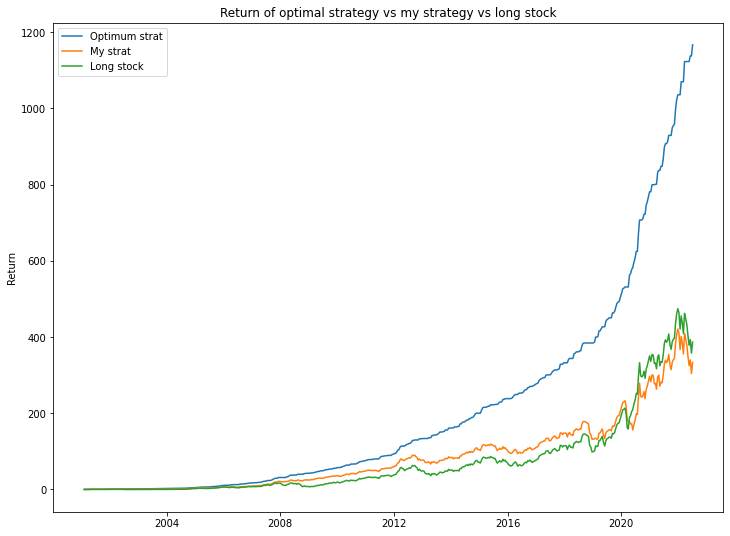

In [23]:
def plot_returns(df):
  # Could shift all these by 1 and then it would be how much money I have made till that date

  plt.figure(figsize=(12,9))
  plt.plot(df['Max_money'].shift(1)/df.Close[0], label='Optimum strat')
  plt.plot(df['Cum_money_made'].shift(1)/df.Close[0], label='My strat')
  plt.plot((df['Close']-df.Close[0])/df.Close[0], label='Long stock')
  plt.title('Return of optimal strategy vs my strategy vs long stock')
  plt.ylabel('Return')
  plt.legend()
  plt.show()

plot_returns(apl_t1)

In [24]:
def stats(df):
  Total_profit=df.Cum_money_made[-2]/df.Close[0] # -2 as we don't earn the last two weeks data as this is not technically included
  Max_profit=df.Max_money[-2]/df.Close[0]
  stock_profit=(df.Close[-1]-df.Close[0])/df.Close[0]
  print('The strategy return is: ', Total_profit)
  print('The optimal strategy return is: ', Max_profit)
  print('The long stock position profit is: ', stock_profit)
  print('Percentage return compared to stock is: ', (Total_profit/stock_profit))
  return Total_profit

stats(apl_t1)

The strategy return is:  333.41021970564526
The optimal strategy return is:  1167.0968263561942
The long stock position profit is:  386.95755927386864
Percentage return compared to stock is:  0.8616196058588292


333.41021970564526

Now we see what the profit would be applying the model to only the test data so we get more of an idea of how much profit the algorithm can create on a shorter term basis.

In [25]:
apl_t2=apl_df.iloc[int(0.8*len(apl_df)):,:]
apl_t2=apl_t2.iloc[::look_forward,:]
apl_t2.head(5)

,Close,Volume,mreturns,returns,Move,momentum,volatility,volume,RSI,momentum_ind,volatility_ind,Volume_ind,RSI_ind
Date,,,,,,,,,,,,,
2018-03-26,43.192501,150164800,1.002778,1.047472,1,0.996973,0.012233,134013860.0,26.869133,0.996933,0.010901,141956100,25.297019
2018-04-10,43.312500,113634400,0.940491,1.018818,0,0.997316,0.017799,136009100.0,43.284733,0.996786,0.013916,103529000,40.523290
2018-04-24,40.735001,134768000,1.141831,0.986081,1,1.000281,0.020020,131312960.0,45.271696,1.001704,0.012818,112885500,59.790703
2018-05-08,46.512501,113611200,1.005966,1.004807,1,1.004455,0.019980,145111500.0,58.373672,1.001152,0.007942,67499200,41.973528
2018-05-22,46.790001,60962800,1.036439,0.997495,1,1.006486,0.015468,128883020.0,81.438783,1.001282,0.006764,52966400,72.445077


The accuracy for the m day strategy is:  0.6111111111111112
108


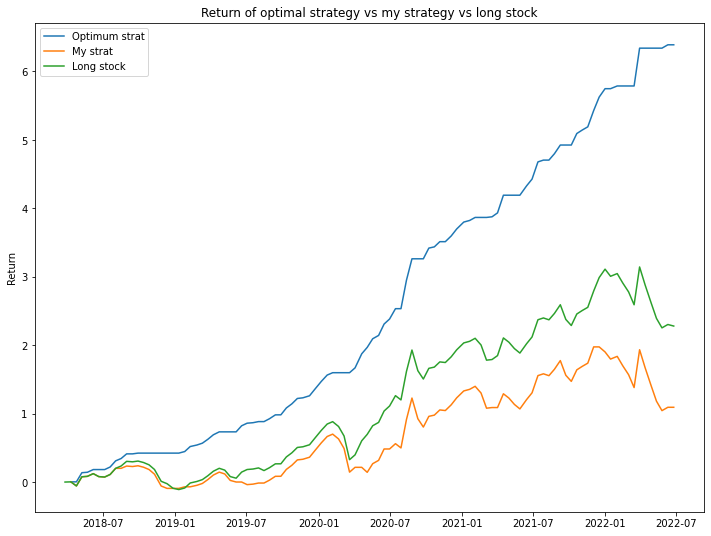

The strategy return is:  1.0926083210601745
The optimal strategy return is:  6.389998161949451
The long stock position profit is:  2.2797360819647836
Percentage return compared to stock is:  0.479269653054977


1.0926083210601745

In [26]:
pred_m_day_moves2=m_day_preds(apl_t2, classifier)
apl_t2=add_predictions(apl_t2, pred_m_day_moves2)
plot_returns(apl_t2)
stats(apl_t2)


In [27]:
def make_dataframe(df1, df2, days_in_past, look_forward):
  '''This function prepares and makes a joint dataframe of stock and index with all the features'''
  df1=prepare(df1)
  df2=prepare(df2)
  df1=feature_calc(df1, days_in_past, look_forward) # we use the past ? days of stock for prediction 2 weeks into future
  df2=feature_calc(df2, days_in_past, look_forward)
  df3=Join(df1, df2)
  return df3

In [28]:
def Maximise_returns(df1,df2, classifier, n):
  profits=[]
  ms=[]
  for m in range(1,60,2):
    df=make_dataframe(df1, df2, n, m)
    df=df.iloc[int(0.8*len(df)):,:]
    df=df.iloc[::m,:]
    pred_m_day=m_day_preds(df, classifier)
    df=add_predictions(df, pred_m_day)
    prof=stats(df)
    profits.append(prof)
    ms.append(m)
  plt.plot(ms, profits)
  plt.xlabel('m')
  plt.ylabel('Returns')
  plt.show()



The accuracy for the m day strategy is:  0.5370370370370371
1080
The strategy return is:  1.771172638765346
The optimal strategy return is:  19.683628039348424
The long stock position profit is:  2.6355859214731936
Percentage return compared to stock is:  0.6720223477955622
The accuracy for the m day strategy is:  0.55
360
The strategy return is:  0.9927155527067207
The optimal strategy return is:  11.97785581259833
The long stock position profit is:  2.460637515296311
Percentage return compared to stock is:  0.4034383555219337
The accuracy for the m day strategy is:  0.6064814814814815
216
The strategy return is:  1.6509477874225016
The optimal strategy return is:  9.49634053258174
The long stock position profit is:  2.5286777071599578
Percentage return compared to stock is:  0.6528897624034247
The accuracy for the m day strategy is:  0.5935483870967742
155
The strategy return is:  2.8084395994755047
The optimal strategy return is:  7.636964930265825
The long stock position profit is:

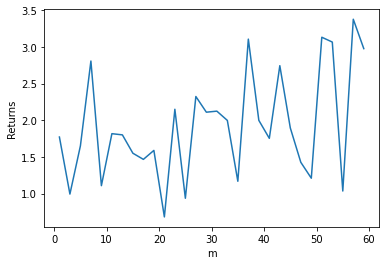

In [29]:
Maximise_returns(pd.read_csv('AAPL.csv'), pd.read_csv('SPY.csv'), classifier, 20)

The returns are quite erratic, cannot really make any conclusion on roughly which values of m will give higher returns.

# Deep Learning model
We can also try and make a deep learning model to see if we can improve our accuracy but with such a limited number of features currently it is unlikely that we will see great improvements to accuracy.

In [30]:
y_train_d=tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_d=tf.keras.utils.to_categorical(y_test, num_classes=2)
y_test_d

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [35]:
model = keras.Sequential()
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_s, y_train_d, epochs=10, validation_data=(X_test_s, y_test_d), batch_size=16)

Epoch 1/10
270/270 [==============================] - 2s 3ms/step - loss: 0.6842 - accuracy: 0.5619 - val_loss: 0.6563 - val_accuracy: 0.6284
Epoch 2/10
270/270 [==============================] - 1s 3ms/step - loss: 0.6760 - accuracy: 0.5819 - val_loss: 0.6662 - val_accuracy: 0.6182
Epoch 3/10
270/270 [==============================] - 1s 2ms/step - loss: 0.6724 - accuracy: 0.5844 - val_loss: 0.6625 - val_accuracy: 0.6219
Epoch 4/10
270/270 [==============================] - 1s 3ms/step - loss: 0.6694 - accuracy: 0.5907 - val_loss: 0.6591 - val_accuracy: 0.6321
Epoch 5/10
270/270 [==============================] - 1s 3ms/step - loss: 0.6708 - accuracy: 0.5884 - val_loss: 0.6664 - val_accuracy: 0.6284
Epoch 6/10
270/270 [==============================] - 1s 3ms/step - loss: 0.6675 - accuracy: 0.5914 - val_loss: 0.6637 - val_accuracy: 0.6395
Epoch 7/10
270/270 [==============================] - 1s 2ms/step - loss: 0.6668 - accuracy: 0.5974 - val_loss: 0.6654 - val_accuracy: 0.6247
Epoch 

We get a similar accuracy using a simple deep learning model as the SVM , but a bit higher

In [36]:
y=model.predict(X_test_s)
y

array([[0.27511215, 0.72488785],
       [0.36884663, 0.6311534 ],
       [0.3806892 , 0.6193108 ],
       ...,
       [0.22009398, 0.779906  ],
       [0.40424386, 0.5957562 ],
       [0.45330876, 0.54669124]], dtype=float32)

108


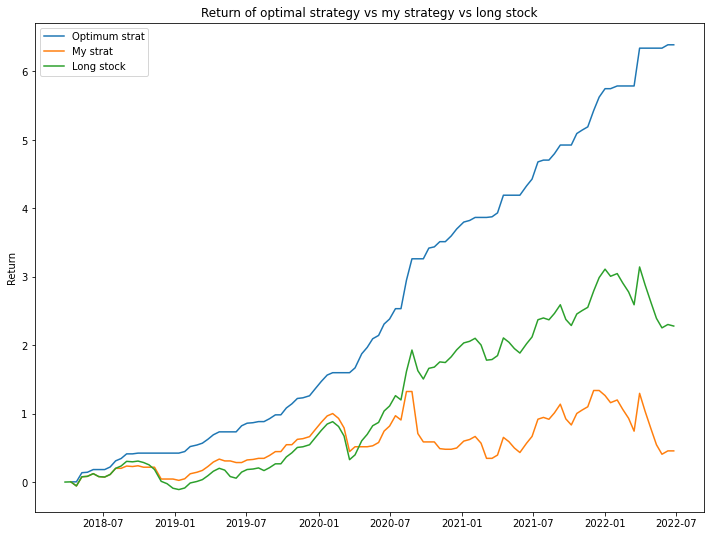

The strategy return is:  0.45546068286251473
The optimal strategy return is:  6.389998161949451
The long stock position profit is:  2.2797360819647836
Percentage return compared to stock is:  0.1997865833969594


1    69
0    39
Name: Move, dtype: int64

In [37]:
def m_day_preds_deep(df, model):
  X=df[features]
  scaler=preprocessing.StandardScaler()
  X=scaler.fit_transform(X)
  y=model.predict(X)
  #print(y)
  ys=[]
  for i in range(len(y)):
    if y[i][1]>0.5:
      ys.append(1)
    else:
      ys.append(0)
  return np.array(ys)


apl_t3=apl_df.iloc[int(0.8*len(apl_df)):,:]
apl_t3=apl_t3.iloc[::look_forward,:]
pred_m_day_moves3=m_day_preds_deep(apl_t3, model)
apl_t3=add_predictions(apl_t3, pred_m_day_moves3)

plot_returns(apl_t3)
stats(apl_t3)
apl_t3.Move.value_counts()


It is worth creating confusion matrices for both our models 

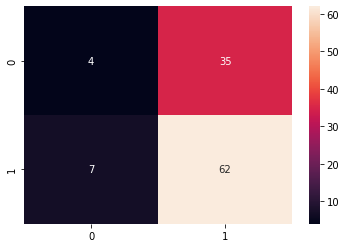

In [38]:
conf_matrix(np.array(apl_t2['Move']), pred_m_day_moves2)

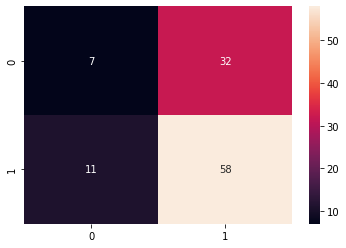

In [39]:
conf_matrix(np.array(apl_t3['Move']), pred_m_day_moves3)

We can check for the robustness or adaptability of the SVM model to different stocks in the S&P500 and see how well the model performs. If we get an accuracy of around 60% then we can say that the model is robust. I have not included this in this notebook but after checking the same SVM model trained on the AAPL data on 10 different stocks in the S&P 500 we get an accuracy of around 55%.